In [1]:
import os
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(44)

In [3]:
import math
import time
import numpy as np
from copy import deepcopy
import pickle
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.nn import functional as F
from torch.utils.data import Subset
from tqdm import tqdm
from matplotlib import pyplot as plt

from data import get_othello, plot_probs, plot_mentals
from data.othello import permit, start_hands, OthelloBoardState, permit_reverse
from mingpt.dataset import CharDataset
from mingpt.model import GPT, GPTConfig, GPTforProbeIA
from mingpt.utils import sample, intervene, print_board
from mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer

plt.rc('text', usetex=True)
plt.rc('font', **{'size': 14.0})
plt.rc('text.latex', preamble=r'\usepackage{lmodern}')

In [4]:
championship = False

In [5]:
mid_dim = 128
how_many_history_step_to_use = 99
exp = f"state_tl{mid_dim}"
if championship:
    exp += "_championship"

## Load a game from intervention benchmark and select an intervention configuration

In [6]:
with open("intervention_benchmark.pkl", "rb") as input_file:
    dataset = pickle.load(input_file)

In [7]:
case_id = 777
wtd = {
    "intervention_position": permit_reverse(dataset[case_id]["pos_int"]), 
    "intervention_from": dataset[case_id]["ori_color"], 
    "intervention_to": 2 - dataset[case_id]["ori_color"], 
}
completion = dataset[case_id]["history"]
print(wtd)

{'intervention_position': 'e6', 'intervention_from': 2.0, 'intervention_to': 0.0}


In [8]:
wtd_list = [wtd]

## Load nonlinear probes

In [9]:
probes = {}
layer_s = 4
layer_e = 9
for layer in range(layer_s, layer_e):
    p = BatteryProbeClassificationTwoLayer(torch.cuda.current_device(), probe_class=3, num_task=64, mid_dim=mid_dim)
    load_res = p.load_state_dict(torch.load(f"./ckpts/battery_othello/{exp}/layer{layer}/checkpoint.ckpt"))
    p.eval()
    probes[layer] = p

## Load trained models

In [10]:
# othello = get_othello(ood_perc=.2, data_root="data/othello_pgn", wthor=False)
othello = get_othello(ood_perc=0., data_root=None, wthor=False, ood_num=1)
train_dataset = CharDataset(othello)

mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)

models = {}
for layer in range(layer_s, layer_e):
    model = GPTforProbeIA(mconf, probe_layer=layer)
    # model = GPT(mconf)
    load_res = model.load_state_dict(torch.load("./ckpts/gpt_synthetic.ckpt" if not championship else "./ckpts/gpt_championship.ckpt"))
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        model = model.to(device)
    _ = model.eval()
    models[layer] = model

100%|██████████| 1/1 [00:00<00:00, 36.48it/s]


Dataset created has 1 sequences, 61 unique words.


### Check the partial game progression

In [11]:
ab = OthelloBoardState()
ab.update(completion, prt=True)

--------------------
[]
a                
b                
c                
d       O X      
e       X O      
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['e6']
a                
b                
c                
d       O X      
e       X X X    
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['e6', 'd6']
a                
b                
c                
d       O O O    
e       X X X    
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['e6', 'd6', 'c3']
a                
b                
c     X          
d       X O O    
e       X X X    
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['e6', 'd6', 'c3', 'f3']
a                
b                
c     X          
d       X O O    
e       O X X    
f     

In [12]:
partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)

### Check pre-intervention ground-truth legal next-steps and the predicted ones

In [13]:
pre_intv_valids = [permit_reverse(_) for _ in ab.get_valid_moves()]
pre_intv_valids

['b4', 'c6', 'd3', 'e7', 'f4', 'f6']

In [14]:
pre_intv_pred, _ = model(partial_game[None, :])  # [B, T, F=512]
# no history activations used here, that's why the prediction map is different to across layers
pre_intv_pred = pre_intv_pred[0, -1, 1:]
padding = torch.zeros(2).cuda()
pre_intv_pred = torch.softmax(pre_intv_pred, dim=0)
pre_intv_pred = torch.cat([pre_intv_pred[:27], padding, pre_intv_pred[27:33], padding, pre_intv_pred[33:]], dim=0)

<AxesSubplot:>

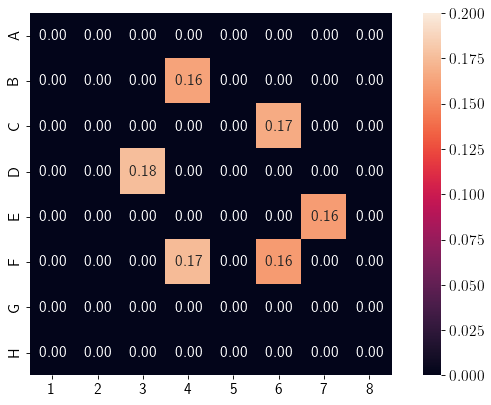

In [15]:
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
vv = 0.2
sns.heatmap(pre_intv_pred.detach().cpu().numpy().reshape(8, 8), vmin=0., vmax=vv, 
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")

## Check post-intervention ground-truth next steps
0 for white; 1 for blank; 2 for black

In [16]:
htd = {"lr": 1e-3, "steps": 1000, "reg_strg": 0.2}
for wtd in wtd_list:
    move = permit(wtd["intervention_position"])
    r, c = move // 8, move % 8
    ab.state[r, c] = wtd["intervention_to"] - 1
ab.__print__()
post_intv_valids = [permit_reverse(_) for _ in ab.get_valid_moves()]
post_intv_valids

--------------------
['e6', 'd6', 'c3', 'f3', 'c4']
a                
b                
c     X X        
d       X X O    
e       O X O    
f     O          
g                
h                
  1 2 3 4 5 6 7 8
--------------------


['b3', 'b4', 'c6', 'd3', 'f4']

## Intervene and observe how the world representation changes along the way

e6 Sucessfully intervened!
e6 Sucessfully intervened!
e6 Sucessfully intervened!
e6 Sucessfully intervened!
e6 Sucessfully intervened!


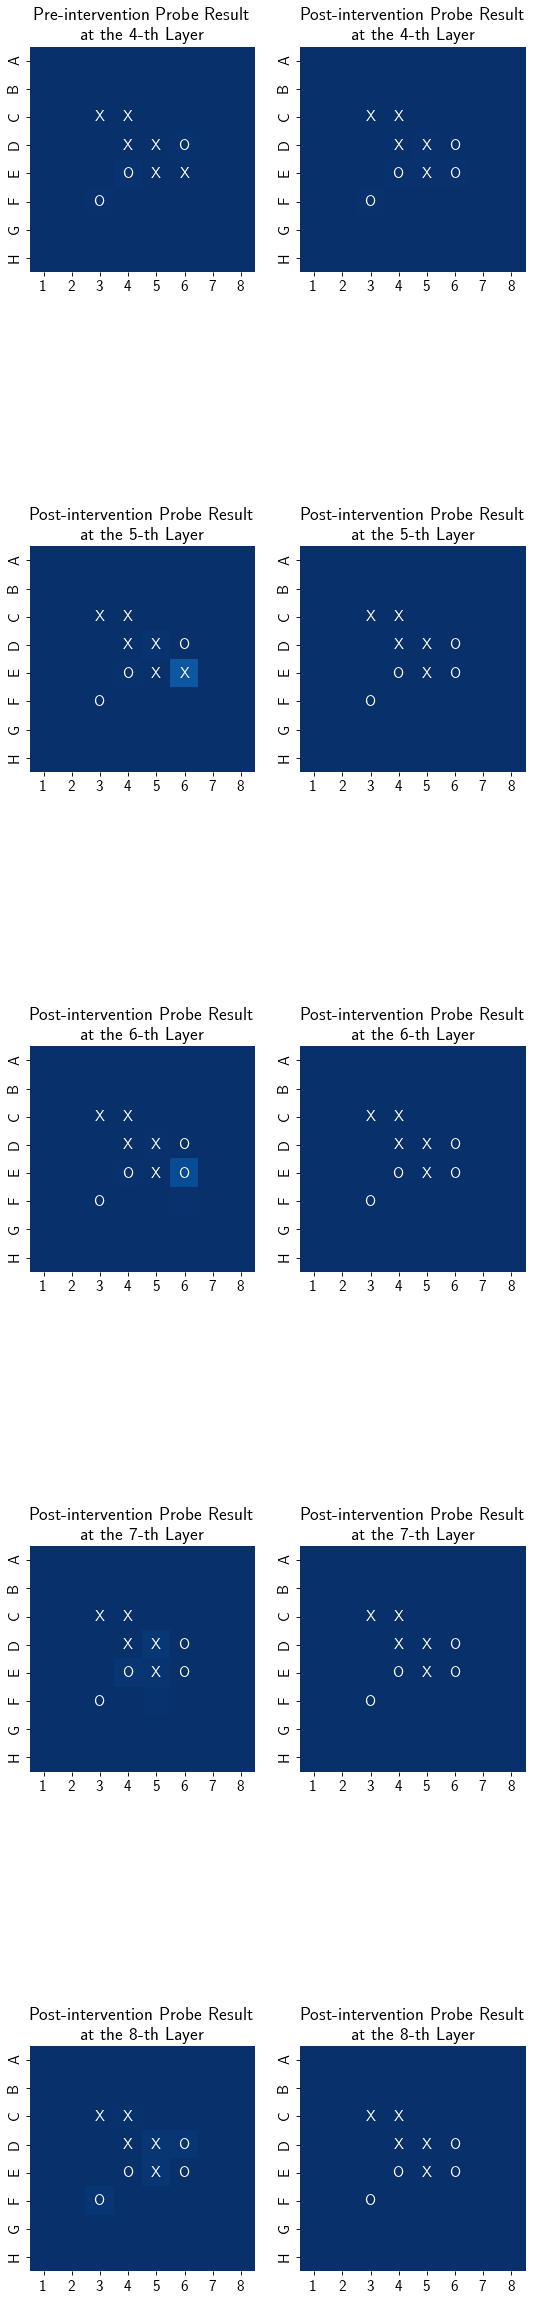

In [17]:
fig, axs = plt.subplots(layer_e - layer_s, 2, figsize=(8 * (1), 8 * (layer_e - layer_s)), dpi= 80, facecolor='w', edgecolor='k')
# two rows for the intervened layer layer_s, one for the rest
if len(axs.shape) == 1:
    axs = axs[:, None]

p = probes[layer_s]
whole_mid_act = models[layer_s].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]

# intervene at the earlest interested layer 
mid_act = whole_mid_act[0, -1]
pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]
plot_mentals(axs[0, 0], pre_intv_logits)
axs[0, 0].set_title(f"Pre-intervention Probe Result \n at the {layer_s}-th Layer")
labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
new_mid_act = mid_act.clone()
for wtd in wtd_list:
    new_mid_act = intervene(p, new_mid_act, labels_pre_intv, wtd, htd, plot=True)
    pre_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
    labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
plot_mentals(axs[0, 1], post_intv_logits)
axs[0, 1].set_title(f"Post-intervention Probe Result \n at the {layer_s}-th Layer")
# swap in 
whole_mid_act[0, -1] = new_mid_act

for i, layer in enumerate(range(layer_s, layer_e - 1)):  # 4, 5, 6, 7, indices of the layers to be passed
    p = probes[layer+1]
    whole_mid_act = models[layer_s].forward_2nd_stage(whole_mid_act, layer, layer+1)[0]  # [1, T, F=512]
    
    # intervene the output of the features freshly out
    mid_act = whole_mid_act[0, -1]
    pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]
    plot_mentals(axs[i+1, 0], pre_intv_logits)
    axs[i+1, 0].set_title(f"Post-intervention Probe Result \n at the {layer+1}-th Layer")
    labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
    new_mid_act = mid_act.clone()
    for wtd in wtd_list:
        new_mid_act = intervene(p, new_mid_act, labels_pre_intv, wtd, htd, plot=True)
        pre_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
        labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
    post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
    plot_mentals(axs[i+1, 1], post_intv_logits)
    axs[i+1, 1].set_title(f"Post-intervention Probe Result \n at the {layer+1}-th Layer")
    # swap in 
    whole_mid_act[0, -1] = new_mid_act

## Compare post-intervention prediction heatmap with pre-intervention ones
Underscored tiles are the ground-truth

Text(0.5, 1.0, 'Post-intervention Prediction Heatmap')

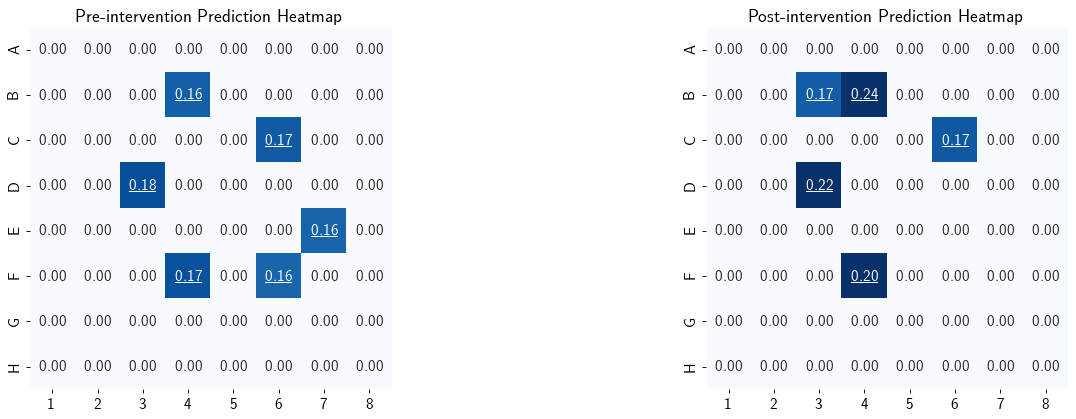

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), dpi= 80, facecolor='w', edgecolor='k')

plot_probs(axs[0], pre_intv_pred, [permit(_) for _ in pre_intv_valids])
axs[0].set_title(f"Pre-intervention Prediction Heatmap")

tb_resumed = whole_mid_act
post_intv_pred, _ = models[layer_s].predict(tb_resumed)
post_intv_pred = post_intv_pred[0, -1, 1:]
post_intv_pred = torch.softmax(post_intv_pred, dim=0)
post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)

plot_probs(axs[1], post_intv_pred, [permit(_) for _ in post_intv_valids])
axs[1].set_title(f"Post-intervention Prediction Heatmap")